In [1]:
# Library Imports

import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()
from gensim.models.doc2vec import TaggedDocument



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
main_data = pd.read_csv('/Users/andrewsimon/Desktop/Dow_dat.csv')
main_data

,Level,Report
0,2,"On April 10th at 12:30 PM, there was an incide..."
1,3,"On April 8th at 9:00 PM, a fire broke out in t..."
2,4,"On April 6th at 2:45 AM, there was an incident..."
3,1,"On April 5th at 7:15 PM, there was an unplanne..."
4,5,"On April 2nd at 11:30 AM, there was a minor in..."
...,...,...
295,3,"At 9:45 AM, a worker reported a small leak of ..."
296,5,"At 2:30 PM, a worker reported a small spill of..."
297,4,"At 6:15 AM, a worker reported an unusual odor ..."
298,2,"At 11:00 AM, a worker reported a small fire in..."


In [3]:
# Tokenizer helper function
def tokenize(report):
    try:
        tokens = tokenizer.tokenize(report)
        return tokens
    except:
        return "NC"
    
# Tokenizer wrapping function
def postprocess(data):
    data['tokens'] = data['Report'].progress_map(tokenize)
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

In [4]:
# Tokenize the data with wrapping functions
data = main_data.copy()
data = postprocess(data)

progress-bar: 100%|██████████| 300/300 [00:00<00:00, 4667.44it/s]


In [5]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(np.array(data.tokens),
                                                    np.array(data.Level), test_size=0.2, random_state=42)

In [6]:
# Attach Doc2vec labels to each of our tokens
def labelizeReports(reports, label_type):
    labelized = []
    for i,v in tqdm(enumerate(reports)):
        label = '%s_%s'%(label_type,i)
        labelized.append(TaggedDocument(v, [label]))
    return labelized

X_train = labelizeReports(X_train, 'TRAIN')
X_test = labelizeReports(X_test, 'TEST')


240it [00:00, 294768.07it/s]
60it [00:00, 665762.54it/s]


In [7]:
# Fit train model
tweet_w2v = Word2Vec(vector_size=300, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(X_train)])
tweet_w2v.train([x.words for x in tqdm(X_train)], total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.epochs)

100%|██████████| 240/240 [00:00<00:00, 1874549.27it/s]


(39106, 90025)

In [8]:
 google_vectors = gensim.downloader.load('word2vec-google-news-300')

In [12]:
# Extract word embeddings
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))


/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# Build word vectors from embeddings
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += google_vectors[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [13]:
# Data postprocessing with sklearn, creating unit standard deviation
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in tqdm(map(lambda x: x.words, X_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in tqdm(map(lambda x: x.words, X_test))])
test_vecs_w2v = scale(test_vecs_w2v)


240it [00:00, 4586.03it/s]

60it [00:00, 6049.62it/s]


In [26]:
clf_decision_tree = DecisionTreeClassifier()
clf_decision_tree.fit(train_vecs_w2v, y_train)
predictions_DT = clf_decision_tree.predict(test_vecs_w2v)
acc_score = accuracy_score(y_test, predictions_DT)
acc_score

0.43333333333333335

In [28]:
classifier = LogisticRegression( max_iter = 100000)
classifier.fit(train_vecs_w2v, y_train)
predictions_LR = classifier.predict(test_vecs_w2v)
score = classifier.score(test_vecs_w2v, y_test)
score

0.7

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=800, random_state=11).fit(train_vecs_w2v, y_train)
predictions = rf.predict(test_vecs_w2v)
score = rf.score(test_vecs_w2v, y_test)
score

0.7166666666666667

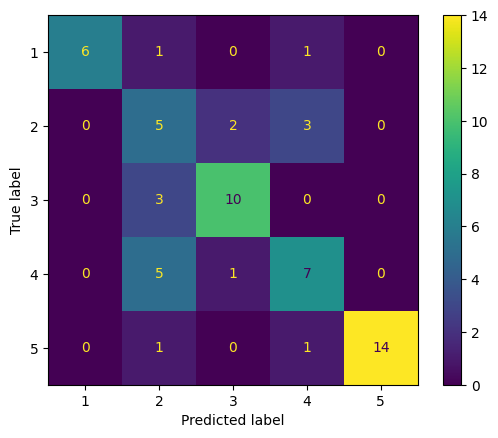

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

len(y_test)
cm = confusion_matrix(y_test, predictions_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [1,2,3,4,5])
disp.plot()

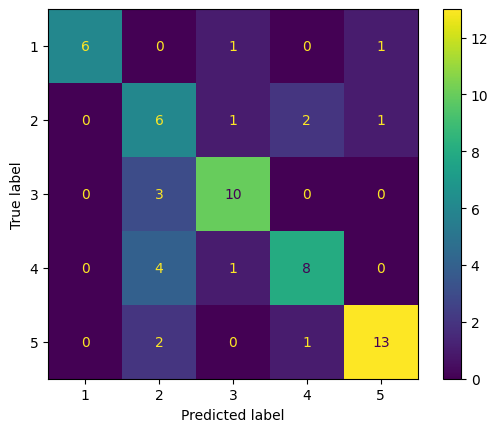

In [29]:

len(y_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [1,2,3,4,5])
disp.plot()

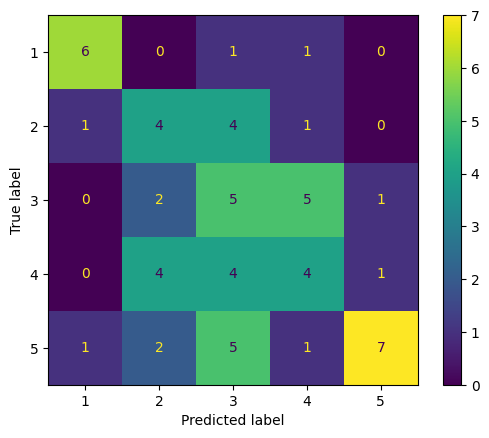

In [31]:

len(y_test)
cm = confusion_matrix(y_test, predictions_DT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [1,2,3,4,5])
disp.plot()

In [35]:
from sklearn import svm

clf = svm.SVC()
clf.fit(train_vecs_w2v, y_train)
SVM_predict = clf.predict(test_vecs_w2v)
score = clf.score(test_vecs_w2v, y_test)
score

0.6666666666666666

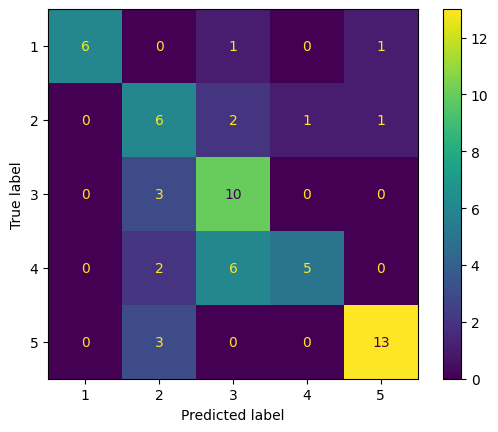

In [36]:
len(y_test)
cm = confusion_matrix(y_test, SVM_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [1,2,3,4,5])
disp.plot()